In [6]:
#importing the necessary libraries

import os
import cv2
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.client import device_lib
from keras.models import Model
from keras import layers, models
from keras.mixed_precision import set_global_policy
from keras.backend import clear_session
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import json
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import gc
from keras.backend import clear_session

In [7]:
#Organizing Pathes

# Define paths
base_dir = Path.cwd().parent
dataset_dir = base_dir / "data\\facescrub"
results_dir = base_dir / "results\\facescrub"

os.makedirs(results_dir, exist_ok=True)

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D,
    BatchNormalization, Dropout, LeakyReLU
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np


In [9]:
# Load preprocessed data
size = 45
X_train = np.load(results_dir / f"X{size}_gray_train.npy", allow_pickle=True)
X_val = np.load(results_dir / f"X{size}_gray_val.npy", allow_pickle=True)
X_test = np.load(results_dir / f"X{size}_gray_test.npy", allow_pickle=True)
y_train = np.load(results_dir / "y_gray_train.npy", allow_pickle=True)
y_val = np.load(results_dir / "y_gray_val.npy", allow_pickle=True)
y_test = np.load(results_dir / "y_gray_test.npy", allow_pickle=True)


# Verify shapes
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

Training set: (30186, 45, 45, 1), Labels: (30186,)
Validation set: (6469, 45, 45, 1), Labels: (6469,)
Test set: (6469, 45, 45, 1), Labels: (6469,)


17


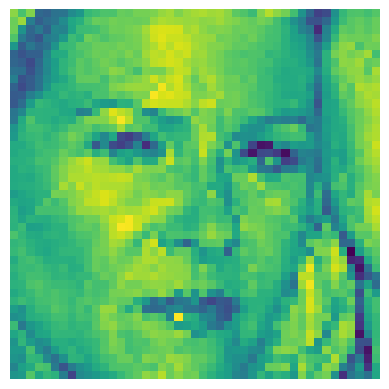

(30186, 45, 45, 1)


In [10]:

plt.imshow(X_train[105])
print(y_train[105])
plt.axis('off')
plt.show()
print(X_train.shape)

In [11]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Compute mean face
image = np.concatenate((X_train, X_val, X_test), axis=0)
mean_face = np.mean(image, axis=0)
normalized_images = image - mean_face

# Reshape images to 2D before calculating covariance
num_images = normalized_images.shape[0]
image_size = normalized_images.shape[1] * normalized_images.shape[2]
normalized_images_2d = normalized_images.reshape(num_images, image_size)

# Perform PCA
cov_matrix = np.cov(normalized_images_2d.T)  # Calculate covariance on the reshaped data
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort eigenfaces by eigenvalues
sorted_indices = np.argsort(-eigenvalues)
eigenvectors = eigenvectors[:, sorted_indices]
eigenfaces = eigenvectors[:, :50]  # Select top 50 eigenfaces

# Project images onto PCA space
projected_images = np.dot(normalized_images_2d, eigenfaces) # Project reshaped data
X_new_train = projected_images[:X_train.shape[0]]
X_new_val = projected_images[X_train.shape[0]:X_train.shape[0] + X_val.shape[0]]
X_new_test = projected_images[X_train.shape[0] + X_val.shape[0]:]

In [12]:
print(X_new_train.shape)
print(X_new_test.shape)
print(y_train.shape)
print(y_test.shape)

(30186, 50)
(6469, 50)
(30186,)
(6469,)


In [13]:
# Flatten the training and test sets
X_new_train = X_new_train.reshape(X_new_train.shape[0], -1)  # Flatten each image to a 1D vector
X_new_test = X_new_test.reshape(X_new_test.shape[0], -1)  # Flatten each image to a 1D vector


svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_new_train, y_train)
y_test_pred_SVM = svm_model.predict(X_new_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred_SVM))

Test Accuracy: 0.22430051012521254


In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_new_train, y_train)
y_test_pred_knn = knn_classifier.predict(X_new_test)
accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print("KNN Accuracy:", accuracy_knn)

KNN Accuracy: 0.10480754366980986


In [16]:
import cv2 as cv
import numpy as np
from skimage.feature import local_binary_pattern
from scipy.stats import mode
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.metrics import accuracy_score , confusion_matrix
def confusion_image(label_test, y_test_pred, cutoff=1):
    # Step 1: Compute the confusion matrix
    cm = confusion_matrix(label_test, y_test_pred)

    # Step 2: Normalize the confusion matrix to range [0, 255]
    cm_normalized = (cm / cm.max()) * 255
    cm_image = Image.fromarray(cm_normalized.astype('uint8'))

    # Step 3: Apply contrast stretching
    cm_image = ImageOps.autocontrast(cm_image, cutoff=cutoff)

    # Step 4: Plot the confusion matrix
    plt.imshow(cm_image, cmap='gray')
    plt.axis('off')
    plt.show()

    # Step 5: Calculate and return accuracy
    accuracy = (cm.diagonal().sum()) / cm.sum()
    print("Accuracy:", accuracy)


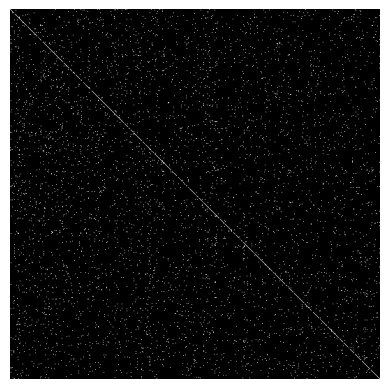

Accuracy: 0.22430051012521254


In [17]:
confusion_image(y_test, y_test_pred_SVM)